In [1]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import shutil
import glob
from scipy import ndimage
from scipy import signal
#import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings
import csv
import tensorflow as tf


/home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# RUN Utility functions

# One time init
# with open('results.csv', 'w') as csvfile:
#     csvout = csv.writer(csvfile)
#     csvout.writerow(["File", "Model", "Gap", "Slice_size", "Count", "Precision", "Recall", "F-score", "True Count", "Error Rate"])

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.91
CUBE_SIZE = 250
EDGE_GAP = 50
ROOT_FOLDER = "/home/il239838/files/"
# ROOT_FOLDER = "/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/files/"
LEARNING_RATE = 0.001
BATCHES = 1000
BATCH_SIZE = 50
BREAK_VAL = 1000

# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image, x_start, x_end, y_start, y_end):
    temp = crop(image, y_start, y_end, x_start, x_end)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, y_start+ymin, y_start+ymax, x_start+xmin, x_start+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name, x_start=X_START, x_end=X_END, y_start=Y_START, y_end=Y_END):
    if "il239838" in os.getcwd():
        image = img.imread(ROOT_FOLDER + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    # return crop_full_scan(image)
    cropped = crop_full_scan(image, x_start, x_end, y_start, y_end)
    return exposure.equalize_adapthist(cropped, clip_limit=0.03)


# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

#     import pdb; pdb.set_trace()
def calc_neighbors(slice_map, col, row):
    # import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    


def VAL_create_cube(name, raw, x, y):
    cube = {}
    cube["cube"] = raw
    cube["file"] = name
    #     if name.find('P') == 0:
    #         cube["index"] = int(name[name.find('P')+1:name.find('P')+4]) * 1000 + int(name[name.find('Fg')+2:name.find('Fg')+5])
    #     else:
    # print("Found a ZERO index cube with the name:"+name)
    cube["index"] = 0
    cube["top_row"] = x
    cube["left_col"] = y
    cube["right_col"] = y + CUBE_SIZE
    return cube
    

ZERO_CUBE = VAL_create_cube("ZERO", np.zeros((CUBE_SIZE, CUBE_SIZE), dtype=np.int), -1, -2)

# slice an image to cubes with 250X250 pixel size
def VAL_slice_TEAR_to_static_slices(name, cropped_original):
    structure = {}
    # cropped_original = cropped_original / 256 # divide by 256 to "normalize" between 0 and 1

    # import pdb; pdb.set_trace()
    x, y = cropped_original["cut"].shape
    # print (x,y)
    n = 0
    # see n offset to see offset in pixels on the x axis == rows. every n equals CUBE_SIZE
    while ((n + 1) * CUBE_SIZE < x):
        # mark the piece as narrow so the first would be counted as lastt too
        narrow = True if ((CUBE_SIZE + (4 * EDGE_GAP)) > y) else False
        # cut a cube of 250X250 at the FIRST column
        start_row_px = int(np.round(n * CUBE_SIZE, -1))
        end_row_px = int(np.round((n + 1) * CUBE_SIZE, -1))
        cube = (crop(cropped_original["cut"], start_row_px, end_row_px, EDGE_GAP, CUBE_SIZE + EDGE_GAP))
        # keep only cubes for which half of the pixels have some "color"
        if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
            # keep the cube
            new_cube = VAL_create_cube(name, cube, start_row_px, EDGE_GAP)
            new_cube["col"] = 0 # marks that the cube is on the first col of the piece
            new_cube["row"] = n
            new_cube["last"] = narrow # marks that the cube is on the last col of the piece
            new_cube["orig"] = cropped_original
            new_cube["col_px_left"] = cropped_original["col_px"] + EDGE_GAP
            new_cube["col_px_right"] = cropped_original["col_px"] + CUBE_SIZE + EDGE_GAP
            new_cube["row_px_top"] = cropped_original["row_px"] + start_row_px
            new_cube["row_px_bottom"] = cropped_original["row_px"] + end_row_px
            structure[(0, n)] = new_cube

        # cut a cube of 250X250 at the LAST column
        cube = (crop(cropped_original["cut"], start_row_px, end_row_px, y - CUBE_SIZE - EDGE_GAP, y - EDGE_GAP))
        # keep only cubes for which half of the pixels have some "color"
        # aligned with the normalization 0.2 correlates to 50
        if np.median(cube) > 0.2:
            # keep the cube
            new_cube = VAL_create_cube(name, cube, start_row_px, y - CUBE_SIZE - EDGE_GAP)
            new_cube["col"] = 1 # marks that the cube is on the last col of the piece
            new_cube["row"] = n
            new_cube["last"] = not narrow # like col - marks that the cube is on the last col of the piece
            new_cube["orig"] = cropped_original
            new_cube["col_px_left"] = cropped_original["col_px"] + y - CUBE_SIZE - EDGE_GAP
            new_cube["col_px_right"] = cropped_original["col_px"] + y - EDGE_GAP
            new_cube["row_px_top"] = cropped_original["row_px"] + start_row_px
            new_cube["row_px_bottom"] = cropped_original["row_px"] + end_row_px
            structure[(1, n)] = new_cube

    #         m = 0
    #         # every 250 pixels on the y axis == cols
    #         while ((m + 1) * CUBE_SIZE < y):            
    #             if ((m == 0) or ((m + 2) * CUBE_SIZE >= y)): # Only keep the left and right edges of the piece for matching!!
    #                 # cut a cube of 250X250
    #                 cube = crop(cropped_original["cut"], n * CUBE_SIZE, (n + 1) * CUBE_SIZE, m * CUBE_SIZE, (m + 1) * CUBE_SIZE)
    #                 # keep only cubes for which half of the pixels have some "color"
    #                 # print(np.median(cube))
    #                 if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
    #                     # keep the cube
    #                     new_cube = VAL_create_cube(name, cube, n * CUBE_SIZE, m * CUBE_SIZE)
    #                     new_cube["col"] = m
    #                     new_cube["row"] = n
    #                     new_cube["orig"] = cropped_original
    #                     new_cube["col_px_left"] = cropped_original["col_px"] + m * CUBE_SIZE
    #                     new_cube["col_px_right"] = cropped_original["col_px"] + (m + 1) * CUBE_SIZE
    #                     new_cube["row_px_top"] = cropped_original["row_px"] + n * CUBE_SIZE
    #                     new_cube["row_px_bottom"] = cropped_original["row_px"] + (n + 1) * CUBE_SIZE
    #                     if ((m + 2) * CUBE_SIZE >= y):
    #                         new_cube["last"] = True
    #                     else:
    #                         new_cube["last"] = False
    #                     structure[(m, n)] = new_cube
    #             m += 1
        n += 0.2 # currently set to jump in 50 px offset
            
    # this loop has to be performed only after we've established all the None cubes
    for cube in structure.values():
        # set the reference to neighbor cubes
        if cube != None:
            calc_neighbors(structure, cube["col"], cube["row"])

    # return the data structure with all the cubes and the counters of the rows and columns
    return structure.values()

def pad_above(original, above, amount):
    res = np.insert(original["cube"], np.zeros(amount), above["cube"][-amount:], axis=0)
    res = np.delete(res, np.arange(CUBE_SIZE,CUBE_SIZE+amount), axis=0)
    cube = VAL_create_cube(original["file"], res, original["top_row"] - amount, original["left_col"])
    cube["col_px_left"] = original["col_px_left"]
    cube["col_px_right"] = original["col_px_right"]
    cube["row_px_top"] = original["row_px_top"] - amount
    cube["row_px_bottom"] = original["row_px_bottom"] - amount
    return cube

def pad_below(original, below, amount):
    res = np.insert(original["cube"], np.full(amount, CUBE_SIZE), below["cube"][:amount], axis=0)
    res = np.delete(res, np.arange(0, amount), axis=0)
    cube =  VAL_create_cube(original["file"], res, original["top_row"] + amount, original["left_col"])
    cube["col_px_left"] = original["col_px_left"]
    cube["col_px_right"] = original["col_px_right"]
    cube["row_px_top"] = original["row_px_top"] + amount
    cube["row_px_bottom"] = original["row_px_bottom"] + amount
    return cube
    
def pad_left(original, left, amount):
    res = np.insert(original["cube"], np.zeros(amount, dtype=int), left["cube"][:,-amount:], axis=1)
    res = np.delete(res, np.arange(CUBE_SIZE, CUBE_SIZE+amount), axis=1)
    cube = VAL_create_cube(original["file"], res, original["top_row"], original["left_col"] - amount)
    cube["col_px_left"] = original["col_px_left"] - amount
    cube["col_px_right"] = original["col_px_right"] - amount
    cube["row_px_top"] = original["row_px_top"]
    cube["row_px_bottom"] = original["row_px_bottom"]
    return cube

def pad_right(original, right, amount):
    res = np.insert(original["cube"], [CUBE_SIZE], right["cube"][:,:amount], axis=1)
    res = np.delete(res, np.arange(0, amount), axis=1)
    cube = VAL_create_cube(original["file"], res, original["top_row"], original["left_col"] + amount)
    cube["col_px_left"] = original["col_px_left"] + amount
    cube["col_px_right"] = original["col_px_right"] + amount
    cube["row_px_top"] = original["row_px_top"]
    cube["row_px_bottom"] = original["row_px_bottom"]
    return cube
    

# "Shave" the right edge of the cube with <gap> pixels and pad with zeros on the left
def shave_right(original, amount):
    return pad_left(original, ZERO_CUBE, amount)
    

# "Shave" the left edge of the cube with <gap> pixels and pad with zeros on the right    
def shave_left(original, amount):
    return pad_right(original, ZERO_CUBE, amount)
    

# concatenate cubes 
def concatenate_cubes(left, right, slice_size):
    con = np.concatenate((left["cube"][:,-slice_size:], right["cube"][:,:slice_size]), axis=1)
    x_delta = right["top_row"] - left["top_row"]
    y_delta = right["left_col"] - left["right_col"] 
    return con, x_delta, y_delta

# concatenate cubes 
def VAL_concatenate_cubes(left, right, slice_size):
    right_img = right["cube"]
    # next block is not relevant for training ...
    #     # if the left cube is matched to another left cube (or right cube to another right cube) then rotate the right
    #     # cube by 180 so we try to match it upside down, covering the option that the cube was pictured rotated
    #     if ((left["col"] == 0 and right["col"] == 0) or (left["col"] != 0 and right["col"] != 0)):
    #         right_img = np.rot90(right["cube"], 2);

    con = np.concatenate((left["cube"][:,-slice_size:], right_img[:,:slice_size]), axis=1)

    # next block calculates distance based on the distance between left's right-top corner and right's left-top corner    
    #     x_delta = right["top_row"] - left["top_row"]
    #     y_delta = right["left_col"] - left["right_col"] 

    # next block calculates the distance between the centers of cubes, accounting for test set's possibility of reverse slices (left instead of right and vice versa)
    x_delta = right["row_px_top"] - left["row_px_top"] # equivalent to distance between vertical centers
    y_delta = (right["col_px_left"] + (slice_size / 2)) - (left["col_px_right"] - (slice_size / 2)) # measuring the distance between horizontal centers of the slices

    return con, x_delta, y_delta, left["file"], right["file"]
    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cube with zeros
def concatenate_cubes_zero_pad_gaps(left_orig, right_orig, gap):
    left = left_orig if gap == 0 else shave_right(left_orig, gap)
    right = right_orig if gap == 0 else shave_left(right_orig, gap)
    return concatenate_cubes(left, right)    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cobe with the nearby
# continuation of the cubes
def concatenate_cubes_with_gap(left_orig, right_orig, gap, left_pad, right_pad, slice_size):
    # import pdb; pdb.set_trace()
    left = left_orig if gap == 0 else pad_left(left_orig, left_pad, gap)
    right = right_orig if gap == 0 else pad_right(right_orig, right_pad, gap)
    return concatenate_cubes(left, right, slice_size)        

# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def VAL_build_train_set_for_euclidean_distance(cubes, slice_size, folder):
    # clean folder before starting
    for root, dirs, files in os.walk(folder):
        for f in files:
            os.unlink(os.path.join(root, f))

    #import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_x_delta = []
    train_y_delta = []
    train_left_obj = []
    train_right_obj = []
    # iterate over all cubes   
    for curr in cubes:
        # iterate over the others (effectively n^2)
        for adj in cubes:
            if (adj["file"] != curr["file"]): # no need to test against self CURRENTLY checking from directions!!!
                #import pdb; pdb.set_trace()
                # append the adjacent image to the current image
                conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr, adj, slice_size)
                output = folder+x_file+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
                np.save(output, conc)
                train_imgs.append(output)
                train_x_delta.append(x_delta)
                train_y_delta.append(y_delta)
                train_left_obj.append(curr)
                train_right_obj.append(adj)

    warnings.filterwarnings("default")
    return train_imgs, train_x_delta, train_y_delta, train_left_obj, train_right_obj


# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def ORIG_build_train_set(cubes, gap):
    # import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_lbls = []
    train_x_delta = []
    train_y_delta = []
    # iterate over the rows and cols, essentially going over the grid of sliced cubes
    for row in range(0, rows):
        for col in range(0, cols):
            # if this cube exists (could have been removed previously due to lack of data)
            if (cubes[(col, row)] != None):
                # for each "current" image in the iteration
                curr = cubes[(col, row)]
                # iterate over all the cubes to find all the "other" (adjacent) cubes
                for adj_row in range(0, rows):
                    for adj_col in range(0, cols):
                        if (adj_row != row or adj_col != col):
                            if (cubes[(adj_col, adj_row)] != None):
                                adj = cubes[(adj_col, adj_row)]
                                # append the adjacent image to the current image
                                # pass the filling cubes on the right and left to pad against the gap
                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                    if (gap == 0):
                                        conc, x_delta, y_delta = concatenate_cubes(curr, adj, slice_size)
                                    else:
                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr, adj, gap, curr["left"], adj["right"], slice_size)
                                    train_imgs.append(conc)
                                    train_x_delta.append(x_delta)
                                    train_y_delta.append(y_delta)
                                    # if the adj image is on the same row and on the right of the curr image - it will be marked as match    
                                    if (adj_row == row and adj_col == (col + 1)):
                                        # mark the image as matched
                                        train_lbls.append([0,1])
                                        # need to enrich the set with a few more tru positive samples - so we offset 
                                        # the matched images up ad down a few times and create more matches
                                        if ("top" in curr.keys() and "top"in adj.keys()):
                                            for i in range(5, 101, 5):
                                                curr1 = pad_above(curr, curr["top"],i)
                                                adj1 = pad_above(adj, adj["top"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys() and "top" in curr["left"].keys() and "top"in curr["right"].keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_above(curr["left"], curr["left"]["top"], i) # FIXIT?
                                                        adj1Right = pad_above(adj["right"], curr["right"]["top"], i) # FIXIT?
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                                            for i in range(5, 101, 5):
                                                curr1 = pad_below(curr, curr["bottom"],i)
                                                adj1 = pad_below(adj, adj["bottom"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys() and "bottom" in curr["left"].keys() and "bottom"in curr["right"].keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_below(curr["left"], curr["left"]["bottom"], i) # FIXIT?
                                                        adj1Right = pad_below(adj["right"], curr["right"]["bottom"], i) # FIXIT?
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("left" in curr.keys()): # enough to check only the curr as the left of the adj is the curr
                                            for i in range(5, 101, 5):
                                                curr1 = pad_left(curr, curr["left"],i)
                                                adj1 = pad_left(adj, adj["left"],i) # essentially the curr
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_left(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        adj1Right = pad_left(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("right" in adj.keys()): # enough to check only the adj as the right of the curr is the adj
                                            for i in range(5, 101, 5):
                                                curr1 = pad_right(curr, curr["right"],i) # essentially the adj
                                                adj1 = pad_right(adj, adj["right"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_right(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        adj1Right = pad_right(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                    else:
                                        # mark the image as not matched
                                        train_lbls.append([1,0])
                                
    warnings.filterwarnings("default")
    return train_imgs, train_lbls, train_x_delta, train_y_delta

In [3]:
# RUN Utility functions 2
SAVE_PNG=False
def save_img(path, img):
    np.save(path, img)  
    if SAVE_PNG:
        plt.imsave(path+".png", img, cmap=plt.cm.gray)
                    
def VAL_add_tolerance_matches(slice_size, folder, train_imgs, train_lbls, train_x_delta, 
                              train_y_delta, is_enriched, curr, adj, tolerance_factor=0):
    # need to enhance the set with a few more true positive samples
    # allowing some up and down tolerance
    if ("top" in curr.keys()):
        for i in range(0, tolerance_factor * 10, 10):
            if i == 0:
                continue
            curr1 = pad_above(curr, curr["top"],i)
            adj1 = adj
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
            # print(">>> MATCH >>>"+output)
            save_img(output, conc)
            # print(">>> >>> >>> SAVED")
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            # mark the image as matched
            train_lbls.append([0,1])
            is_enriched.append(True)
    if ("top" in adj.keys()):
        for i in range(0, tolerance_factor * 10, 10):
            if i == 0:
                continue
            curr1 = curr
            adj1 = pad_above(adj, adj["top"],i)
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
            # print(">>> MATCH >>>"+output)
            save_img(output, conc)
            # print(">>> >>> >>> SAVED")
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            # mark the image as matched
            train_lbls.append([0,1])
            is_enriched.append(True)
    if ("bottom" in curr.keys()):
        for i in range(0, tolerance_factor * 10, 10):
            if i == 0:
                continue
            curr1 = pad_below(curr, curr["bottom"],i)
            adj1 = adj
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
            # print(">>> MATCH >>>"+output)
            save_img(output, conc)
            # print(">>> >>> >>> SAVED")
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            # mark the image as matched
            train_lbls.append([0,1])
            is_enriched.append(True)
    if ("bottom"in adj.keys()):
        for i in range(0, tolerance_factor * 10, 10):
            if i == 0:
                continue
            curr1 = curr
            adj1 = pad_below(adj, adj["bottom"],i)
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
            # print(">>> MATCH >>>"+output)
            save_img(output, conc)
            # print(">>> >>> >>> SAVED")
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            # mark the image as matched
            train_lbls.append([0,1])
            is_enriched.append(True)

                            
# IMPORTANT: enrich_factor determines how many "duplications" of TRUE values will we have in the train set
# This allows for a more balanced train set however, it reduces the strictness of the matches 
# i.e. (not sure why) when we have multiple nearby "duplicates" matches we get much more matches in the validation
# PARAMS: enrich_factor=1 means no enrich/duplicate, 20 means duplicate by 20, every 10 pixels
# PARAMS: tolerance_factor=0 means only match against exact horizon, each notch equals additional 10 pixels tolerance
def NEW_build_train_set_for_binary_labeling(cubes, slice_size, folder, enrich_factor=1, tolerance_factor=0): 
    # enrich_factor is split by 2 because it is dual-sided and 1 means actually no enrichment - i.e. 0.5
    enrich_factor = enrich_factor / 2 
    # clean folder before starting
    for root, dirs, files in os.walk(folder):
        for f in files:
            os.unlink(os.path.join(root, f))

    warnings.filterwarnings("ignore")

    train_imgs = []
    train_lbls = []
    train_x_delta = []
    train_y_delta = []
    is_enriched = []
    discard_c = 0

    # import pdb; pdb.set_trace()

    # iterate over the cubes
    for curr in cubes:
        # iterate over the others (effectively n^2)
        for adj in cubes:
            # Initial filter: what CAN be matched against what?
            # 1 - not of the same fragment (file==fragment)
            # 2 - they ARE of the same tear - don't want to confuse the learning with false data coming from different tears
            # 3 - no need to test against self and avoid checking from both directions
            if  adj["file"] != curr["file"] and \
                adj["tear"] == curr["tear"] and \
                curr["piece_col"] < adj["piece_col"]: 
                # last condition above - actually ignores pieces of the same col but different rows
                # the assumption is that they are either "not-match" and then will tilt the balance further to not-match
                # or they are "somewhat-matching" but in a way that might confuse the algorithm
                
                # print(">>> >>>"+str(curr["cube"].shape)+" <<< <<<"+str(adj["cube"].shape))
                # append the adjacent image to the current image
                conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr, adj, slice_size)

                train_x_delta.append(x_delta)
                train_y_delta.append(y_delta)
                                
                # Condition for marking as match:
                # 1 - the adj piece is on the same row as the curr
                # 2 - the adj piece is just to the right of the curr
                # 3 - the curr cube is on the right edge of the piece
                # 4 - the adj cube is on the left edge of the piece
                # 5 - the cubes are in the same horizon
                if  curr["piece_row"] == adj["piece_row"] and \
                    curr["piece_col"] + 1 == adj["piece_col"] and \
                    (curr["col"] != 0 or curr["last"]) and \
                    (adj["col"] == 0 or not adj["last"]) and \
                    np.abs(x_delta) < 50: 

                    # print(x_delta, y_delta)
                    
                    # mark the image as matched
                    output = folder+"0_1="+x_file+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
                    # print(">>> MATCH >>>"+output)
                    save_img(output, conc)
                    # print(">>> >>> >>> SAVED")
                    train_imgs.append(output)
                    train_lbls.append([0,1])
                    is_enriched.append(False)

                    #import pdb; pdb.set_trace()
                    # TOLERANCE
                    VAL_add_tolerance_matches(slice_size, folder, train_imgs, train_lbls, train_x_delta, 
                                              train_y_delta, is_enriched, curr, adj, tolerance_factor)
                    
                    # ENRICH/DUPLICATE
                    # need to enrich the set with a few more true positive samples - so we offset 
                    # the matched images up and down a few times and create more matches
                    if ("top" in curr.keys() and "top" in adj.keys()):
                        for i in range(0, 121, int(120/enrich_factor)):
                            if i == 0:
                                continue
                            curr1 = pad_above(curr, curr["top"],i)
                            adj1 = pad_above(adj, adj["top"],i)
                            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
                            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
                            # print(">>> MATCH >>>"+output)
                            save_img(output, conc)
                            # print(">>> >>> >>> SAVED")
                            train_imgs.append(output)
                            train_x_delta.append(x_delta)
                            train_y_delta.append(y_delta)
                            # mark the image as matched
                            train_lbls.append([0,1])
                            is_enriched.append(True)

                            # TOLERANCE
                            VAL_add_tolerance_matches(slice_size, folder, train_imgs, train_lbls, train_x_delta, 
                                                      train_y_delta, is_enriched, curr1, adj1, tolerance_factor)
                            
                    if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                        for i in range(0, 121, int(120/enrich_factor)):
                            if i == 0:
                                continue
                            curr1 = pad_below(curr, curr["bottom"],i)
                            adj1 = pad_below(adj, adj["bottom"],i)
                            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr1, adj1, slice_size)
                            output = folder+"1_1="+x_file+"_"+str(curr1["top_row"])+"_"+str(curr1["left_col"])+"---"+y_file+"_"+str(adj1["top_row"])+"_"+str(adj1["left_col"])
                            # print(">>> MATCH >>>"+output)
                            save_img(output, conc)
                            # print(">>> >>> >>> SAVED")
                            train_imgs.append(output)
                            train_x_delta.append(x_delta)
                            train_y_delta.append(y_delta)
                            # mark the image as matched
                            train_lbls.append([0,1])
                            is_enriched.append(True)

                            # TOLERANCE
                            VAL_add_tolerance_matches(slice_size, folder, train_imgs, train_lbls, train_x_delta, 
                                                      train_y_delta, curr1, adj1, tolerance_factor)
 
                # adding a condition for marking as not-matched - we mark only the "key" cubes which are every 250px
                # and not overlap - hence we reduce the ratio in favour of not matched which is enormous
                elif int(curr["row"]) == curr["row"] and int(adj["row"]) == adj["row"]: # this condition will match curr key cubes with adj key cubes only
                # elif int(adj["row"]) == adj["row"]: # this condition will allow curr cubes which are not just key
                    # mark the image as not matched
                    output = folder+"0_0="+x_file+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
                    # print("<<< nonmatch <<<"+output)
                    save_img(output, conc)
                    # print("<<< <<< <<< SAVED")
                    train_imgs.append(output)
                    train_lbls.append([1,0]) # not matched
                    is_enriched.append(False)
                
                # discard not matched which are not "key" cubes (every 250px)
                else:
                    discard_c += 1
                    
    print("*** MATCHED="+str(sum(x[1] == 1 for x in train_lbls)))
    print("*** NOT MATCHED="+str(sum(x[0] == 1 for x in train_lbls)))
    print("*** DISCARDED="+str(discard_c))
    warnings.filterwarnings("default")
    return train_imgs, train_lbls, train_x_delta, train_y_delta, is_enriched


def frame_to_n_by_m(orig, start_vector, end_vector, is_col):
    max_val = np.amax(end_vector)
    min_val = np.amin(start_vector)
    width = max_val - min_val
    if width < CUBE_SIZE:
        width = CUBE_SIZE
    if (is_col):
        result = np.zeros((start_vector.size, width))
    else:
        result = np.zeros((width, start_vector.size))
    
    for i in range(0, start_vector.size):
        if (is_col):
            row_vec = orig[i, start_vector[i]:end_vector[i]]
        else:
            row_vec = orig[start_vector[i]:end_vector[i],i]
        temp = np.lib.pad(row_vec, (start_vector[i]-min_val, max_val-end_vector[i]), 'constant', constant_values=(0.09, 0.09))
        if (is_col):
            if (result[i].size != width):
                import pdb; pdb.set_trace()
            result[i] = temp[0:width]
        else:
            result[:,i] = temp[0:width]
    return min_val, result

def rough_tear_line(orig, start_vector, cut_mean, is_col, chew_factor):
    end_vector = np.empty(start_vector.size).astype(int)
    if (is_col and np.absolute(cut_mean-orig.shape[1]) < 10):
        end_vector.fill(orig.shape[1])
    elif (not is_col and np.absolute(cut_mean-orig.shape[0]) < 10):
        end_vector.fill(orig.shape[0])
    else:
        deviation_vector = np.random.normal(0, chew_factor, start_vector.size).astype(int)
        end_vector[0] = cut_mean + deviation_vector[0]
        for i in range(1, end_vector.size):
            end_vector[i] = end_vector[i - 1] + deviation_vector[i]

        cut_max = start_vector + (CUBE_SIZE + EDGE_GAP)
        max_and_end = np.append([end_vector], [cut_max], axis=0)
        end_vector = np.amax(max_and_end, axis=0)
            
    start_px, cut_piece = frame_to_n_by_m(orig, start_vector, end_vector, is_col)    
    return start_px, cut_piece, end_vector

def rough_tear_image(image, cols, rows):
    pieces = []
    col_width = int(image.shape[1] / cols)
    row_height = int(image.shape[0] / rows)
    # print(col_width, row_height)
    next_col_start_vec = np.zeros((image.shape[0],), dtype=int)
    for col_idx in range(0, cols):
    #         import pdb; pdb.set_trace()
        start_col_px, cut_column, next_col_start_vec =  rough_tear_line(image, next_col_start_vec, col_width * (col_idx + 1), True, 3)
        next_row_start_vec = np.zeros((cut_column.shape[1],), dtype=int)
        for row_idx in range(0, rows):
            start_row_px, cut_piece, next_row_start_vec = rough_tear_line(cut_column, next_row_start_vec, row_height * (row_idx + 1), False, 1)

            ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(cut_piece, cutoff=BG_2_OBJ_RATIO)
            temp = crop(cut_piece, ymin, ymax, xmin, xmax)
            
            #import pdb; pdb.set_trace()
            piece = {}
            piece["orig"] = cut_piece
            piece["cut"] = temp
            piece["col"] = col_idx
            piece["row"] = row_idx
            piece["col_px"] = start_col_px + xmin
            piece["row_px"] = start_row_px + ymin
            pieces.append(piece)
            
    return pieces

In [4]:
# RUN Define model util functions

# initialize a shaped matrix of weights with random values
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# initialize a shaped matrix of bias with random values
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

def max_pool_2x1(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 1, 1],
                        strides=[1, 2, 1, 1], padding='SAME')

def max_pool_1x1(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],
                        strides=[1, 1, 1, 1], padding='SAME')

def max_pool_5x5(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 5, 1],
                        strides=[1, 5, 5, 1], padding='SAME')

def max_pool_5x2(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 2, 1],
                        strides=[1, 5, 2, 1], padding='SAME')


In [5]:
# RUN Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    


In [6]:
# RUN model_tf_deep - Define the model - 250, 125, 62, 25
def model_tf_deep(input_width, forced_bias=0): 
    global accuracy, correct_prediction, train_step, x, y_, y_conv, keep_prob, probability, probabilities #, W_fc, b_fc, cost, y_conv_temp
    
    # foundation of the model - the input layer of the image 250 x input_width*2
    x = tf.placeholder(tf.float32, [None, 250, input_width*2], "001")
    x_image = tf.reshape(x, [-1,250,input_width*2,1], "0011") # 1 is the number of color channels

    # the target digits of the model
    y_ = tf.placeholder(tf.float32, [None, 2], "002") # 1

    # zero convolutional layer: one input image and 32 output filters of 5x5
    W_conv0 = weight_variable([5, 5, 1, 32])
    b_conv0 = bias_variable([32])
    h_conv0 = tf.nn.relu(conv2d(x_image, W_conv0) + b_conv0, "0020")
    h_pool0 = max_pool_1x1(h_conv0) # size is maintained

    # first convolutional layer: one input image and 32 output filters of 5x5
    W_conv1 = weight_variable([5, 5, 32, 32])
#     W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1, "0021")
#     h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, "0021")
    if (input_width == 250):
        h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250
    elif (input_width == 125):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x250
    elif (input_width == 62):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x50
    else:
        print("ERROR - unsupported slice width")
        return

    # second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv2 = weight_variable([5, 5, 32, 32])
    b_conv2 = bias_variable([32])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, "0022")
    if (input_width == 62):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x50
    else:
        h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125


    # third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv3 = weight_variable([5, 5, 32, 32])
    b_conv3 = bias_variable([32])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, "0023")
    if (input_width == 25):
        h_pool3 = max_pool_5x2(h_conv3) # size is reduced to 25x25
    else:
        h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


    h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*32]) # shape as an array 

    # fourth layer - fully connected with input 25*25*128 and output 1024
    W_fc1 = weight_variable([25*25*32, 1024])
    b_fc1 = bias_variable([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1, "0024")

    # a drop layer with probability 
    keep_prob = tf.placeholder(tf.float32, name="003")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="0031")

    #     # final layer - reduce to one "class" for the linear regression
    #     W_fc = weight_variable([1024, 1]) 
    #     b_fc = bias_variable([1])         
    #     y_conv_temp = tf.matmul(h_fc1_drop, W_fc, name="0032") + b_fc
    #     y_conv = tf.minimum(y_conv_temp, tf.constant(BREAK_VAL, tf.float32))

    #     #     # minimize loss function
    #     #     cross_entropy = tf.reduce_mean(
    #     #       tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    #     # cost = tf.reduce_sum(tf.pow(y_conv - y_, 2))/(2*BATCHES*BATCH_SIZE) # Mean squared error
    #     cost = tf.reduce_mean(tf.square(y_conv_temp - y_), name="0033") # Mean squared error

    #     #     # define train step and rate
    #     #     train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #     train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost) # Gradient descent

    #     # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    #     correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    #     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # final layer - softmax reduction 2 outputs
    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])
    c_fc2 = tf.constant([0, forced_bias], dtype=tf.float32)
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2 + c_fc2

    # minimize loss function
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
      # tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

    probability = tf.nn.softmax(y_conv,1)
    
    probabilities=tf.reduce_sum(probability,1)
    
    # define train step and rate
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# RUN model_tf_orig - Define the model - 250, 125, 62, 25
def model_tf_orig(input_width): 
    global accuracy, correct_prediction, train_step, x, y_, y_conv, keep_prob #, W_fc, b_fc, cost, y_conv_temp
    
    # foundation of the model - the input layer of the image 250 x input_width*2
    x = tf.placeholder(tf.float32, [None, 250, input_width*2], "001")
    x_image = tf.reshape(x, [-1,250,input_width*2,1], "0011") # 1 is the number of color channels

    # the target digits of the model
    y_ = tf.placeholder(tf.float32, [None, 2], "002") # 1

    # zero convolutional layer: one input image and 32 output filters of 5x5
#     W_conv0 = weight_variable([5, 5, 1, 32])
#     b_conv0 = bias_variable([32])
#     h_conv0 = tf.nn.relu(conv2d(x_image, W_conv0) + b_conv0, "0020")
#     h_pool0 = max_pool_1x1(h_conv0) # size is maintained

    # first convolutional layer: one input image and 32 output filters of 5x5
#     W_conv1 = weight_variable([5, 5, 32, 32])
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
#     h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1, "0021")
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, "0021")
    if (input_width == 250):
        h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250
    elif (input_width == 125):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x250
    elif (input_width == 62):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x50
    else:
        print("ERROR - unsupported slice width")
        return

    # second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv2 = weight_variable([5, 5, 32, 32])
    b_conv2 = bias_variable([32])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, "0022")
    if (input_width == 62):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x50
    else:
        h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125


    # third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv3 = weight_variable([5, 5, 32, 32])
    b_conv3 = bias_variable([32])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, "0023")
    if (input_width == 25):
        h_pool3 = max_pool_5x2(h_conv3) # size is reduced to 25x25
    else:
        h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


    h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*32]) # shape as an array 

    # fourth layer - fully connected with input 25*25*128 and output 1024
    W_fc1 = weight_variable([25*25*32, 1024])
    b_fc1 = bias_variable([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1, "0024")

    # a drop layer with probability 
    keep_prob = tf.placeholder(tf.float32, name="003")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="0031")

    #     # final layer - reduce to one "class" for the linear regression
    #     W_fc = weight_variable([1024, 1]) 
    #     b_fc = bias_variable([1])         
    #     y_conv_temp = tf.matmul(h_fc1_drop, W_fc, name="0032") + b_fc
    #     y_conv = tf.minimum(y_conv_temp, tf.constant(BREAK_VAL, tf.float32))

    #     #     # minimize loss function
    #     #     cross_entropy = tf.reduce_mean(
    #     #       tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    #     # cost = tf.reduce_sum(tf.pow(y_conv - y_, 2))/(2*BATCHES*BATCH_SIZE) # Mean squared error
    #     cost = tf.reduce_mean(tf.square(y_conv_temp - y_), name="0033") # Mean squared error

    #     #     # define train step and rate
    #     #     train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #     train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost) # Gradient descent

    #     # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    #     correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    #     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # final layer - softmax reduction 2 outputs
    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # minimize loss function
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

    # define train step and rate
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
# RUN model_tf_wide - Define the model - 250, 125, 62, 25
def model_tf_wide(input_width): 
    global accuracy, correct_prediction, train_step, x, y_, y_conv, keep_prob #, W_fc, b_fc, cost, y_conv_temp
    
    # foundation of the model - the input layer of the image 250 x input_width*2
    x = tf.placeholder(tf.float32, [None, 250, input_width*2], "001")
    x_image = tf.reshape(x, [-1,250,input_width*2,1], "0011") # 1 is the number of color channels

    # the target digits of the model
    y_ = tf.placeholder(tf.float32, [None, 2], "002") # 1

    # first convolutional layer: one input image and 32 output filters of 5x5
    W_conv1 = weight_variable([5, 5, 1, 64])
    b_conv1 = bias_variable([64])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, "0021")
    if (input_width == 250):
        h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250
    elif (input_width == 125):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x250
    elif (input_width == 62):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x50
    else:
        print("ERROR - unsupported slice width")
        return

    # second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv2 = weight_variable([5, 5, 64, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, "0022")
    if (input_width == 62):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x50
    else:
        h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125


    # third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv3 = weight_variable([5, 5, 64, 64])
    b_conv3 = bias_variable([64])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, "0023")
    if (input_width == 25):
        h_pool3 = max_pool_5x2(h_conv3) # size is reduced to 25x25
    else:
        h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


    h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*64]) # shape as an array 

    # fourth layer - fully connected with input 25*25*128 and output 1024
    W_fc1 = weight_variable([25*25*64, 2048])
    b_fc1 = bias_variable([2048])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1, "0024")

    # a drop layer with probability 
    keep_prob = tf.placeholder(tf.float32, name="003")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="0031")

    #     # final layer - reduce to one "class" for the linear regression
    #     W_fc = weight_variable([1024, 1]) 
    #     b_fc = bias_variable([1])         
    #     y_conv_temp = tf.matmul(h_fc1_drop, W_fc, name="0032") + b_fc
    #     y_conv = tf.minimum(y_conv_temp, tf.constant(BREAK_VAL, tf.float32))

    #     #     # minimize loss function
    #     #     cross_entropy = tf.reduce_mean(
    #     #       tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    #     # cost = tf.reduce_sum(tf.pow(y_conv - y_, 2))/(2*BATCHES*BATCH_SIZE) # Mean squared error
    #     cost = tf.reduce_mean(tf.square(y_conv_temp - y_), name="0033") # Mean squared error

    #     #     # define train step and rate
    #     #     train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #     train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost) # Gradient descent

    #     # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    #     correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    #     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # final layer - softmax reduction 2 outputs
    W_fc2 = weight_variable([2048, 2])
    b_fc2 = bias_variable([2])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # minimize loss function
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

    # define train step and rate
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# RUN train
def train(train_imgs, train_lbls, output_model, input_model=""):
    print("#####################################################################")
    print("TRAINING:")
    print("MODEL:"+output_model)
    print("#####################################################################")

    from random import randrange
    
    # TRAIN Prepare the session

    # create a saver object
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()
    if input_model != "":
        # Restore variables from disk.
        saver.restore(sess, input_model)
        print("Model restored.")
    else:
        sess.run(tf.initialize_all_variables())

    # TRAIN Train the model
    x_batch = []
    y_batch = []
    # run the train batches
    for i in range(BATCHES):
        x_batch = []
        y_batch = []
        for _ in range(1):
            random_index = randrange(0,len(train_imgs))
            image = np.load(train_imgs[random_index]+".npy")
            print(train_imgs[random_index])
            x_batch.append(image)
            y_batch.append(train_lbls[random_index])

        # train
        # print("step %d"%(i))
        train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})

        # print the accuracy thus far
        if (i+1)%50 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:x_batch, y_: y_batch, keep_prob: 1.0})
            print("step %d, training accuracy %.2f"%(i, train_accuracy))


    print("Optimization Finished!")
    train_accuracy = accuracy.eval(feed_dict={
        x:x_batch, y_: y_batch, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))

    # Save the variables to disk.
    save_path = saver.save(sess, output_model)
    print("Model saved in file: %s" % save_path)

    # Close the Session when we're done. If un-commented - need to run next bock of restore...
    sess.close()   
    print("#####################################################################")
    print("TRAINING ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")    

In [10]:
# RUN pre_process - OLD?
def pre_process(folder):
    print("#####################################################################")
    print("PRE_PROCESS:"+folder)
    print("#####################################################################")
    result = []
    
    for root, dirs, files in os.walk(folder):
        for file_ in files:
            # Read the image
            # image = img.imread(os.path.join(root, file_))
            image = np.load(os.path.join(root, file_))
            # import pdb; pdb.set_trace()
            cubes = VAL_slice_to_static_slices(file_, image)
            print("File: %s >>> cubes: %d"%(file_, len(cubes)))
            result.extend(cubes)
    
    return result
    print("#####################################################################")
    print("PRE_PROCESS ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [11]:
# RUN pre_process_training - crop image, then tear it randomly to various tears, then per tear create cubes out of the edges, return cube set
def pre_process_training(img_name, x_start=X_START, x_end=X_END, y_start=Y_START, y_end=Y_END, max_cols=8, max_rows=4):
    print("#####################################################################")
    print("PRE_PROCESS:"+img_name)
    print("#####################################################################")
    short_name = img_name[:img_name.rfind('-D')]
    image = read_and_crop(img_name, x_start, x_end, y_start, y_end)
    result = []
    
    for root, dirs, files in os.walk(ROOT_FOLDER+"fragments/"):
        for f in files:
            os.unlink(os.path.join(root, f))

    
    for col_cut in range(3, max_cols): # 9 3...10
        for row_cut in range(2, max_rows): # 6 2...5
            print("PRE_PROCESS:::"+"TEAR_"+str(col_cut)+"X"+str(row_cut))
            pieces = rough_tear_image(image, col_cut, row_cut)
            
            for piece in pieces:
                # print("PRE_PROCESS:::"+"PIECE_"+str(piece["col"])+"X"+str(piece["row"]))
                fragment_name = short_name + "_TEAR_"+str(col_cut)+"X"+str(row_cut)+"_PIECE_"+str(piece["col"])+"X"+str(piece["row"])
                fragment_file_name = short_name + "_"+str(col_cut)+"X"+str(row_cut)+"_"+str(piece["col"])+"X"+str(piece["row"])
                # import pdb; pdb.set_trace()
                plt.imsave(os.path.join(ROOT_FOLDER+"fragments/",fragment_file_name+".jpg"), piece["cut"], cmap=plt.cm.gray)
                cubes = VAL_slice_TEAR_to_static_slices(fragment_name, piece)
                for cube in cubes:
                    cube["tear"] = str(col_cut)+"X"+str(row_cut)
                    cube["piece_col"] = piece["col"]
                    cube["piece_row"] = piece["row"]
                # print("File: %s >>> cubes: %d"%(file_, len(cubes)))
                result.extend(cubes)
    
    return result
    print("#####################################################################")
    print("PRE_PROCESS ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [12]:
def validate1(cubes, model, slice_size, folder, curr_cube):    
    # VALIDATE prepare the data sets
    test_imgs, test_x_delta, test_y_delta, test_x_file, test_y_file = VAL_build_train_set(cubes, slice_size, folder, curr_cube)
    print("loaded %d images"%(len(test_imgs)))

In [13]:
def validate2(folder, model, slice_size):
    test_imgs = []
    test_x_file = []
    test_y_file = []
    the_root = ""
    for root, dirs, files in os.walk(folder):
        the_root = root
        for file_ in files:
            test_imgs.append( os.path.join(root, file_) )
            test_x_file.append(file_[:file_.rfind('---P')])
            test_y_file.append(file_[file_.rfind('---P')+3:])
            
    print(len(test_imgs))
    
    # VALIDATE Prepare a test session 

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()

    # Restore variables from disk.
    saver.restore(sess, model)
    print("Model restored.")

    # VALIDATE Validate the model

    # import pdb; pdb.set_trace()
    v1t = []
    count = 0
    length = len(test_imgs)
    batch = 100
    x_batch = []
    # change the ranges in the loop below - first number is the start point (multiplied by batch size)
    # second number is the end point (multiplied by batch size)
    # third number is the jump from batch to batch
    # use the length about to set the batch length
    for start in range(0, length, batch):
        for i in range(start, start+batch):
            if (i < length):
                image = np.load(test_imgs[i])
                x_batch.append(image)
                count += 1

        # print("Validating start at #%d end at %d"%(start*batch,(start+length)*batch))
        my_prediction=tf.argmax(y_conv,1)
        v1 = my_prediction.eval(feed_dict={x:x_batch, keep_prob: 1.0})
        v1t = np.concatenate((v1t, v1), axis=0)
        x_batch = []
        print(">>> step %d"%(start+batch))


    match_indexes = np.nonzero(v1t)[0]
    A = np.array(test_x_file)
    B = np.array(test_y_file)
    C = np.array(test_imgs)
    match_x_files = A[match_indexes]
    match_y_files = B[match_indexes]
    match_images = C[match_indexes]
    
    for matched_img in match_images:
        load_img = np.load(matched_img)
        plt.imsave(os.path.join("/Volumes/250GB/matched/",matched_img[matched_img.rfind('/')+1:]+".png"), load_img, cmap=plt.cm.gray)
    
    for root, dirs, files in os.walk(folder):
        for file_ in files:
            os.remove( os.path.join(root, file_) ) # delete it from the FS
                
    with open('matches.csv', 'a') as csvfile:
        csvout = csv.writer(csvfile)
        for match_index in match_indexes:
            print("MATCH %s === %s"%(test_x_file[match_index], test_y_file[match_index]))
            # print("MATCH %s === %s"%(A[match_index], B[match_index]))
            # csvout.writerow([A[match_index], B[match_index]])
            csvout.writerow([test_x_file[match_index], test_y_file[match_index]])
            # plt.imsave("match_"+match_index+".jpg", C[match_index])

    # Close the Session when we're done.
    sess.close()   

In [14]:
def validate2_for_cross_validation(test_imgs, test_lbls, is_enriched, model, max_samples=0):
    print(len(test_imgs))
    
    # VALIDATE Prepare a test session 

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()

    # Restore variables from disk.
    saver.restore(sess, model)
    print("Model restored.")

    # VALIDATE Validate the model

    count = 0
    se = 0
    st = 0
    v1t = []
    v2t = []
    v1tt = []
    v2tt = []
    length = len(test_imgs)
    if max_samples != 0:
        length = max_samples
    batch = 100
    x_batch = []
    y_batch = []
    # change the ranges in the loop below - first number is the start point (multiplied by batch size)
    # second number is the end point (multiplied by batch size)
    # third number is the jump from batch to batch
    # use the length about to set the batch length
    for start in range(0, length, batch):
        for i in range(start, start+batch):
            if (i < length):
                image = np.load(test_imgs[i]+".npy")
                x_batch.append(image)
                y_batch.append(train_lbls[i])                
                
        # print the accuracy thus far
    #         train_accuracy = accuracy.eval(feed_dict={
    #             x:x_batch, y_: y_batch, keep_prob: 1.0})
    #         print("step %d, training accuracy %g"%(i, train_accuracy))

        # print("Validating start at #%d end at %d"%(start*batch,(start+length)*batch))
    #         my_prediction=tf.argmax(y_conv,1)
    #         v1 = my_prediction.eval(feed_dict={x:x_batch, keep_prob: 1.0})
    #         v1t = np.concatenate((v1t, v1), axis=0)

        ######## printing the predictions and their normalized values
        # print("y_conv="+str(y_conv.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})))
        # print("probability="+str(probability.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})))
        # print("probabilities="+str(probabilities.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})))
        
        my_prediction=tf.argmax(y_conv,1)
        my_target=tf.argmax(y_,1)
        v1 = my_prediction.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
        v2 = my_target.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
        v1t = np.concatenate((v1t, v1), axis=0)
        v2t = np.concatenate((v2t, v2), axis=0)

        c1 = np.sum(np.absolute(np.subtract(v2, v1)))
        c2 = np.sum(np.absolute(v2))
        se += c1
        st += c2

        x_batch = []
        y_batch = []
        print(">>> step %d"%(start+batch))
        
        count += ((i+1) - start)
        precision, recall, f_score, support = precision_recall_fscore_support(v2t, v1t, average='binary')
        print("step %d-%d, precision %f, recall %f, f_score %f"%(start, i, precision, recall, f_score))
        # print("Accumulated total true = %d"%(st));
        # print("Accumulated total error rate = %f"%(se/count));
        # v1tt = np.concatenate((v1tt, v1t), axis=0)
        # v2tt = np.concatenate((v2tt, v2t), axis=0)
        print("=== total %d match %d"%(count, len(np.nonzero(v1t)[0])))

    precision, recall, f_score, support = precision_recall_fscore_support(v2t, v1t, average='binary')
    print("TOTAL %d, precision %f, recall %f, f_score %f"%(count, precision, recall, f_score))
    print("TOTAL true = %d"%(st));
    print("TOTAL error rate = %f"%(se/count));
    
    match_indexes = np.nonzero(v1t)[0]
    C = np.array(test_imgs)
    match_images = C[match_indexes]
    
    # for matched_img in match_images:
    #    load_img = np.load(matched_img+".npy")
    #    plt.imsave(os.path.join(ROOT_FOLDER+"synt_matched/",matched_img[matched_img.rfind('/')+1:]+".png"), load_img, cmap=plt.cm.gray)

    with open('synt_all.csv', 'a') as csvfile:
        csvout = csv.writer(csvfile)
        for idx, test_img in enumerate(test_imgs):
            # print("MATCH %s === %s"%(test_imgs[match_index], train_lbls[match_index]))
            match_class = 0
            if idx in match_indexes:
                match_class = 1
            csvout.writerow([test_img, train_lbls[idx], match_class, is_enriched[idx]])
            # plt.imsave("match_"+match_index+".jpg", C[match_index])

    with open('synt_matches.csv', 'a') as csvfile:
        csvout = csv.writer(csvfile)
        for match_index in match_indexes:
            # print("MATCH %s === %s"%(test_imgs[match_index], train_lbls[match_index]))
            csvout.writerow([test_imgs[match_index], train_lbls[match_index], is_enriched[match_index]])
            # plt.imsave("match_"+match_index+".jpg", C[match_index])

    # Close the Session when we're done.
    sess.close()   

In [15]:
def iter_validate(cubes, model, slice_size, folder):
    print("#####################################################################")
    print("VALIDATING")
    print("#####################################################################")
    cubes_len = len(cubes)
    batch_size = 100
    count = 0
    # iterate over the cubes
    for curr in cubes:
        count += 1
        if count < batch_size: ### TEMP LIMITATION
            print("CUBE:%s"%(curr["file"]+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])))
            validate1(cubes, model, slice_size, folder, curr)
            validate2(folder, model, slice_size)
        
    print("#####################################################################")
    print("VALIDATION ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [16]:
def run_all(folder, model, slice_size):
    model_tf(slice_size)
    cubes_set = pre_process(folder)
    validate(cubes_set, model, slice_size)

In [17]:
# HELPER block
# image = read_and_crop("PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112602-ML924__012.jpg")
## image = read_and_crop("PX303/FG004/PX303-Fg004-V-C01-R01-D08032015-T110900-ML924__012.jpg", 100, -1, 400, -1)
# image = read_and_crop("PX303/FG004/PX303-Fg004-V-C01-R02-D08032015-T105147-ML924__012.jpg")
# image = read_and_crop("PX303/FG004/PX303-Fg004-V-C02-R01-D08032015-T110025-ML924__012.jpg")
# image = read_and_crop("PX303/FG004/PX303-Fg004-V-C02-R02-D08032015-T105553-ML924__012.jpg")
# image = read_and_crop("PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120605-ML924__012.jpg")
# image = read_and_crop("PX303/FG006/PX303-Fg006-V-C01-R02-D08032015-T115230-ML924__012.jpg")
# image = read_and_crop("PX303/FG006/PX303-Fg006-V-C02-R01-D08032015-T120158-ML924__012.jpg")
##image = read_and_crop("PX303/FG006/PX303-Fg006-V-C02-R02-D08032015-T115704-ML924__012.jpg", 0, 6200, 0, 4400)
##plt.imshow(image)

In [18]:
def load_train_from_disk(path):
    train_imgs = []
    train_lbls = []
    is_enriched = []
    for root, dirs, files in os.walk(path):
        for file_ in files:
            file_name = os.path.join(root, file_)
            file_name = file_name[:file_name.rfind(".")]
            train_imgs.append(file_name)
    #        train_lbls.append([1,0] if file_.startswith("0=") else [0,1])
    # return train_imgs, train_lbls
            enriched = file_[0] == '1'
            is_enriched.append(enriched)
            label = [0,1] if file_[2] == '1' else [1,0] 
            train_lbls.append(label)
    return train_imgs, train_lbls, is_enriched

In [ ]:
# RUN1 - take 1st large pieces and train on it
cubes_set = pre_process_training("PX303-Fg001-V-C01-R01-D05032015-T112520-ML638__006.jpg", max_cols=8, max_rows=6)
train_imgs, train_lbls, train_x_delta, train_y_delta, is_enriched = \
    NEW_build_train_set_for_binary_labeling(cubes_set, CUBE_SIZE, ROOT_FOLDER + "train_concats/", 1, 5)
tf.reset_default_graph()
model_tf_deep(250)
train(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model1.ckpt")

#####################################################################
PRE_PROCESS:PX303-Fg001-V-C01-R01-D05032015-T112520-ML638__006.jpg
#####################################################################
PRE_PROCESS:::TEAR_3X2


/home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


PRE_PROCESS:::TEAR_3X3
PRE_PROCESS:::TEAR_3X4
PRE_PROCESS:::TEAR_3X5
PRE_PROCESS:::TEAR_4X2
PRE_PROCESS:::TEAR_4X3
PRE_PROCESS:::TEAR_4X4
PRE_PROCESS:::TEAR_4X5
PRE_PROCESS:::TEAR_5X2
PRE_PROCESS:::TEAR_5X3
PRE_PROCESS:::TEAR_5X4


In [ ]:
# RE-RUN1 - take 1st large pieces and train on it
train_imgs, train_lbls, is_enriched = \
    load_train_from_disk(ROOT_FOLDER + "train_concats/")
tf.reset_default_graph()
model_tf_deep(250)
train(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model1.ckpt")

In [ ]:
# RUN2 - take 2nd large pieces and train on it
cubes_set = pre_process_training("PX303-Fg004-V-C01-R01-D08032015-T110817-ML638__006.jpg", 100, -1, 400, -1, max_cols=8, max_rows=4)
train_imgs, train_lbls, train_x_delta, train_y_delta, is_enriched = \
    NEW_build_train_set_for_binary_labeling(cubes_set, CUBE_SIZE, 
                                            ROOT_FOLDER + "train_concats2/", 1, 7)
tf.reset_default_graph()
model_tf_deep(250)
train(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model2.ckpt", ROOT_FOLDER + "model_binary/tear_model1.ckpt")

In [ ]:
# RE-RUN2 - take 2nd large pieces and train on it
train_imgs, train_lbls, is_enriched = \
    load_train_from_disk(ROOT_FOLDER + "train_concats2/")
tf.reset_default_graph()
model_tf_deep(250)
train(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model2.ckpt", ROOT_FOLDER + "model_binary/tear_model1.ckpt")

In [ ]:
# OPTIONAL RUN3 - take 3rd large pieces and train on it OR TEST in next block

# cubes_set = pre_process_training("PX303/FG006/PX303-Fg006-V-C02-R02-D08032015-T115622-ML638__006.jpg", 0, 6200, 0, 4400, max_cols=8, max_rows=4)
# train_imgs, train_lbls, train_x_delta, train_y_delta, is_enriched = \
#     NEW_build_train_set_for_binary_labeling(cubes_set, CUBE_SIZE, ROOT_FOLDER + "train_concats/")
# tf.reset_default_graph()
# model_tf(250)    
# train(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model3.ckpt", ROOT_FOLDER + "model_binary/tear_model2.ckpt")


In [ ]:
# TEST3 - take 1 piece and cross- validate on this (uncomment all for full test run)
cubes_set = pre_process_training("PX303-Fg006-V-C02-R02-D08032015-T115622-ML638__006.jpg", 0, 6200, 0, 4400, max_cols=8, max_rows=4)
train_imgs, train_lbls, train_x_delta, train_y_delta, is_enriched = \
    NEW_build_train_set_for_binary_labeling(cubes_set, CUBE_SIZE, ROOT_FOLDER + "train_concats3/", 1, 7)
tf.reset_default_graph()
model_tf_deep(250, 1)    
validate2_for_cross_validation(train_imgs, train_lbls, is_enriched, ROOT_FOLDER + "model_binary/tear_model2.ckpt")

In [ ]:
# RE-TEST3 - take 1 piece and cross- validate on this (uncomment all for full test run)
train_imgs, train_lbls, is_enriched = \
    load_train_from_disk(ROOT_FOLDER + "train_concats3/")
tf.reset_default_graph()
model_tf_deep(250, 1)    
validate2_for_cross_validation(train_imgs, train_lbls, ROOT_FOLDER + "model_binary/tear_model2.ckpt")

In [ ]:
#### STOP

In [ ]:
len(train_imgs)

In [ ]:
sum(x[1] == 1 for x in train_lbls)

In [ ]:
#####################################################################
TRAINING:
MODEL:/Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
#####################################################################
step 49, training accuracy 0.78
step 99, training accuracy 0.84
step 149, training accuracy 0.9
step 199, training accuracy 0.92
step 249, training accuracy 0.88
step 299, training accuracy 0.84
step 349, training accuracy 0.92
step 399, training accuracy 0.86
Optimization Finished!
step 399, training accuracy 0.86
Model saved in file: /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
deper network
#####################################################################
TRAINING:
MODEL:/Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
#####################################################################
step 49, training accuracy 0.84
step 99, training accuracy 0.94
step 149, training accuracy 0.86
step 199, training accuracy 0.92
step 249, training accuracy 0.88
step 299, training accuracy 0.92
step 349, training accuracy 0.96
step 399, training accuracy 0.96
Optimization Finished!
step 399, training accuracy 0.96
Model saved in file: /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
deeper network on GCP
#####################################################################
TRAINING:
MODEL:/home/il239838/files/model_binary/tear_model1.ckpt
#####################################################################
WARNING:tensorflow:From /home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 49, training accuracy 0.82
step 99, training accuracy 0.92
step 149, training accuracy 0.72
step 199, training accuracy 0.8
step 249, training accuracy 0.88
step 299, training accuracy 0.88
step 349, training accuracy 0.94
step 399, training accuracy 0.84
Optimization Finished!
step 399, training accuracy 0.84
Model saved in file: /home/il239838/files/model_binary/tear_model1.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
  
 

In [ ]:
#####################################################################
TRAINING:
MODEL:/Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model2.ckpt
#####################################################################
INFO:tensorflow:Restoring parameters from /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
Model restored.
step 49, training accuracy 0.76
step 99, training accuracy 0.82
step 149, training accuracy 0.96
step 199, training accuracy 0.86
step 249, training accuracy 0.76
step 299, training accuracy 0.82
step 349, training accuracy 0.86
step 399, training accuracy 0.88
Optimization Finished!
step 399, training accuracy 0.88
Model saved in file: /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model2.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
deeper network
#####################################################################
TRAINING:
MODEL:/Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model2.ckpt
#####################################################################
INFO:tensorflow:Restoring parameters from /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model1.ckpt
Model restored.
step 49, training accuracy 0.88
step 99, training accuracy 0.88
step 149, training accuracy 0.88
step 199, training accuracy 0.88
step 249, training accuracy 0.92
step 299, training accuracy 0.92
step 349, training accuracy 0.86
step 399, training accuracy 0.94
Optimization Finished!
step 399, training accuracy 0.94
Model saved in file: /Users/il239838/Downloads/private/Thesis/Papyrus/model_binary_new_X6/tear_model2.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
deeper network on GCP
#####################################################################
TRAINING:
MODEL:/home/il239838/files/model_binary/tear_model2.ckpt
#####################################################################
INFO:tensorflow:Restoring parameters from /home/il239838/files/model_binary/tear_model1.ckpt
Model restored.
step 49, training accuracy 0.88
step 99, training accuracy 0.96
step 149, training accuracy 0.84
step 199, training accuracy 0.84
step 249, training accuracy 0.84
step 299, training accuracy 0.92
step 349, training accuracy 0.98
step 399, training accuracy 0.9
Optimization Finished!
step 399, training accuracy 0.9
Model saved in file: /home/il239838/files/model_binary/tear_model2.ckpt
#####################################################################
TRAINING ENDED
#####################################################################
 

In [ ]:
#####################################################################
>>> step 100
step 0-99, precision 0.695652, recall 0.640000, f_score 0.666667
>>> step 200
step 100-199, precision 0.512500, recall 0.732143, f_score 0.602941
>>> step 300
step 200-299, precision 0.350427, recall 0.732143, f_score 0.473988
>>> step 400
step 300-399, precision 0.408805, recall 0.677083, f_score 0.509804
>>> step 500
step 400-499, precision 0.366834, recall 0.651786, f_score 0.469453
>>> step 600
step 500-599, precision 0.349282, recall 0.651786, f_score 0.454829
>>> step 700
step 600-699, precision 0.376471, recall 0.662069, f_score 0.480000
>>> step 800
step 700-799, precision 0.383142, recall 0.595238, f_score 0.466200
>>> step 900
step 800-899, precision 0.394649, recall 0.617801, f_score 0.481633
>>> step 1000
step 900-999, precision 0.407821, recall 0.651786, f_score 0.501718
>>> step 1100
step 1000-1099, precision 0.404432, recall 0.651786, f_score 0.499145
>>> step 1200
step 1100-1199, precision 0.423559, recall 0.657588, f_score 0.515244
>>> step 1300
step 1200-1299, precision 0.408983, recall 0.662835, f_score 0.505848
>>> step 1400
step 1300-1399, precision 0.405640, recall 0.667857, f_score 0.504723
>>> step 1500
step 1400-1499, precision 0.415020, recall 0.670927, f_score 0.512821
>>> step 1600
step 1500-1599, precision 0.402852, recall 0.672619, f_score 0.503902
>>> step 1700
step 1600-1699, precision 0.401681, recall 0.647696, f_score 0.495851
>>> step 1800
step 1700-1799, precision 0.387987, recall 0.647696, f_score 0.485279
>>> step 1900
step 1800-1899, precision 0.385484, recall 0.647696, f_score 0.483316
>>> step 2000
step 1900-1999, precision 0.388802, recall 0.647668, f_score 0.485909
>>> step 2100
step 2000-2099, precision 0.379161, recall 0.650124, f_score 0.478976
>>> step 2200
step 2100-2199, precision 0.374286, recall 0.650124, f_score 0.475068
>>> step 2300
step 2200-2299, precision 0.381868, recall 0.651054, f_score 0.481385
>>> step 2400
step 2300-2399, precision 0.392622, recall 0.659292, f_score 0.492155
>>> step 2500
step 2400-2499, precision 0.393604, recall 0.665281, f_score 0.494590
>>> step 2600
step 2500-2599, precision 0.392601, recall 0.664646, f_score 0.493623
>>> step 2700
step 2600-2699, precision 0.389810, recall 0.664646, f_score 0.491412
>>> step 2800
step 2700-2799, precision 0.384884, recall 0.655446, f_score 0.484982
>>> step 2900
step 2800-2899, precision 0.390572, recall 0.664122, f_score 0.491873
>>> step 3000
step 2900-2999, precision 0.401064, recall 0.679279, f_score 0.504348
>>> step 3100
step 3000-3099, precision 0.418534, recall 0.695431, f_score 0.522568
>>> step 3200
step 3100-3199, precision 0.430129, recall 0.704545, f_score 0.534154
>>> step 3300
step 3200-3299, precision 0.446036, recall 0.716258, f_score 0.549735
>>> step 3400
step 3300-3399, precision 0.448563, recall 0.722388, f_score 0.553459
>>> step 3500
step 3400-3499, precision 0.455204, recall 0.719599, f_score 0.557650
>>> step 3600
step 3500-3599, precision 0.456560, recall 0.718271, f_score 0.558266
>>> step 3700
step 3600-3699, precision 0.457841, recall 0.724000, f_score 0.560950
>>> step 3800
step 3700-3799, precision 0.455285, recall 0.720721, f_score 0.558047
>>> step 3900
step 3800-3899, precision 0.459969, recall 0.724351, f_score 0.562650
>>> step 4000
step 3900-3999, precision 0.445289, recall 0.724351, f_score 0.551529
>>> step 4100
step 4000-4099, precision 0.442598, recall 0.724351, f_score 0.549461
>>> step 4200
step 4100-4199, precision 0.445596, recall 0.725301, f_score 0.552040
>>> step 4300
step 4200-4299, precision 0.429793, recall 0.724760, f_score 0.539597
>>> step 4400
step 4300-4399, precision 0.426450, recall 0.724760, f_score 0.536955
>>> step 4500
step 4400-4499, precision 0.427491, recall 0.727485, f_score 0.538528
>>> step 4600
step 4500-4599, precision 0.427310, recall 0.723820, f_score 0.537377
>>> step 4700
step 4600-4699, precision 0.422999, recall 0.723820, f_score 0.533956
>>> step 4800
step 4700-4799, precision 0.419893, recall 0.723820, f_score 0.531474
>>> step 4900
step 4800-4899, precision 0.423740, recall 0.723669, f_score 0.534504
>>> step 5000
step 4900-4999, precision 0.428387, recall 0.725683, f_score 0.538742
>>> step 5100
step 5000-5099, precision 0.417348, recall 0.725683, f_score 0.529928
>>> step 5200
step 5100-5199, precision 0.414482, recall 0.725683, f_score 0.527612
>>> step 5300
step 5200-5299, precision 0.412935, recall 0.725683, f_score 0.526358
>>> step 5400
step 5300-5399, precision 0.418093, recall 0.720759, f_score 0.529207
>>> step 5500
step 5400-5499, precision 0.409934, recall 0.720294, f_score 0.522502
>>> step 5600
step 5500-5599, precision 0.409280, recall 0.719665, f_score 0.521805
>>> step 5700
step 5600-5699, precision 0.411176, recall 0.716189, f_score 0.522422
>>> step 5800
step 5700-5799, precision 0.413056, recall 0.707921, f_score 0.521707
>>> step 5900
step 5800-5899, precision 0.408427, recall 0.701061, f_score 0.516152
>>> step 6000
step 5900-5999, precision 0.404113, recall 0.701061, f_score 0.512694
>>> step 6100
step 6000-6099, precision 0.399565, recall 0.700382, f_score 0.508839
>>> step 6200
step 6100-6199, precision 0.398913, recall 0.700382, f_score 0.508310
>>> step 6300
step 6200-6299, precision 0.402681, recall 0.704503, f_score 0.512453
>>> step 6400
step 6300-6399, precision 0.404178, recall 0.709441, f_score 0.514970
>>> step 6500
step 6400-6499, precision 0.402955, recall 0.713255, f_score 0.514974
>>> step 6600
step 6500-6599, precision 0.402532, recall 0.713645, f_score 0.514730
>>> step 6700
step 6600-6699, precision 0.413011, recall 0.712585, f_score 0.522933
>>> step 6800
step 6700-6799, precision 0.416506, recall 0.713813, f_score 0.526059
>>> step 6900
step 6800-6899, precision 0.421002, recall 0.712439, f_score 0.529253
>>> step 7000
step 6900-6999, precision 0.428773, recall 0.709176, f_score 0.534427
>>> step 7100
step 7000-7099, precision 0.430497, recall 0.704718, f_score 0.534488
>>> step 7200
step 7100-7199, precision 0.437929, recall 0.695273, f_score 0.537381
>>> step 7300
step 7200-7299, precision 0.440254, recall 0.693133, f_score 0.538483
>>> step 7400
step 7300-7399, precision 0.441348, recall 0.690577, f_score 0.538525
>>> step 7500
step 7400-7499, precision 0.439821, recall 0.688375, f_score 0.536719
>>> step 7600
step 7500-7599, precision 0.440693, recall 0.683196, f_score 0.535782
>>> step 7700
step 7600-7699, precision 0.440618, recall 0.676152, f_score 0.533547
>>> step 7800
step 7700-7799, precision 0.435618, recall 0.676152, f_score 0.529865
>>> step 7900
step 7800-7899, precision 0.431701, recall 0.674044, f_score 0.526316
>>> step 8000
step 7900-7999, precision 0.429482, recall 0.668651, f_score 0.523021
>>> step 8100
step 8000-8099, precision 0.428027, recall 0.667768, f_score 0.521672
>>> step 8200
step 8100-8199, precision 0.429717, recall 0.664057, f_score 0.521784
>>> step 8300
step 8200-8299, precision 0.428451, recall 0.664057, f_score 0.520849
>>> step 8400
step 8300-8399, precision 0.429589, recall 0.660438, f_score 0.520569
>>> step 8500
step 8400-8499, precision 0.428870, recall 0.660438, f_score 0.520041
>>> step 8600
step 8500-8599, precision 0.427618, recall 0.660438, f_score 0.519119
>>> step 8700
step 8600-8699, precision 0.424528, recall 0.655478, f_score 0.515310
>>> step 8800
step 8700-8799, precision 0.421074, recall 0.655478, f_score 0.512757
>>> step 8900
step 8800-8899, precision 0.420032, recall 0.650814, f_score 0.510555
>>> step 9000
step 8900-8999, precision 0.415667, recall 0.650814, f_score 0.507317
>>> step 9100
step 9000-9099, precision 0.414201, recall 0.646154, f_score 0.504808
>>> step 9200
step 9100-9199, precision 0.414510, recall 0.642944, f_score 0.504053
>>> step 9300
step 9200-9299, precision 0.413793, recall 0.639138, f_score 0.502352
>>> step 9400
step 9300-9399, precision 0.408101, recall 0.639138, f_score 0.498134
>>> step 9500
step 9400-9499, precision 0.407789, recall 0.639138, f_score 0.497902
>>> step 9600
step 9500-9599, precision 0.408248, recall 0.639218, f_score 0.498268
>>> step 9700
step 9600-9699, precision 0.406097, recall 0.639218, f_score 0.496663
>>> step 9800
step 9700-9799, precision 0.408482, recall 0.639487, f_score 0.498524
>>> step 9900
step 9800-9899, precision 0.407298, recall 0.639098, f_score 0.497524
>>> step 10000
step 9900-9999, precision 0.406250, recall 0.639098, f_score 0.496741
>>> step 10100
step 10000-10099, precision 0.407407, recall 0.636312, f_score 0.496758
>>> step 10200
step 10100-10199, precision 0.408892, recall 0.636415, f_score 0.497892
>>> step 10300
step 10200-10299, precision 0.407852, recall 0.636415, f_score 0.497120
>>> step 10400
step 10300-10399, precision 0.408796, recall 0.637079, f_score 0.498024
>>> step 10500
step 10400-10499, precision 0.406452, recall 0.637079, f_score 0.496280
>>> step 10600
step 10500-10599, precision 0.405540, recall 0.637989, f_score 0.495875
>>> step 10700
step 10600-10699, precision 0.403583, recall 0.636918, f_score 0.494087
>>> step 10800
step 10700-10799, precision 0.401748, recall 0.636918, f_score 0.492710
>>> step 10900
step 10800-10899, precision 0.402490, recall 0.636066, f_score 0.493011
>>> step 11000
step 10900-10999, precision 0.400619, recall 0.633496, f_score 0.490836
>>> step 11100
step 11000-11099, precision 0.396798, recall 0.633496, f_score 0.487958
>>> step 11200
step 11100-11199, precision 0.396944, recall 0.629510, f_score 0.486880
>>> step 11300
step 11200-11299, precision 0.397928, recall 0.628496, f_score 0.487316
>>> step 11400
step 11300-11399, precision 0.398474, recall 0.625521, f_score 0.486826
>>> step 11500
step 11400-11499, precision 0.397233, recall 0.620690, f_score 0.484435
>>> step 11600
step 11500-11599, precision 0.396189, recall 0.620690, f_score 0.483658
>>> step 11700
step 11600-11699, precision 0.397906, recall 0.620725, f_score 0.484945
>>> step 11800
step 11700-11799, precision 0.397856, recall 0.618999, f_score 0.484381
>>> step 11900
step 11800-11899, precision 0.396184, recall 0.618999, f_score 0.483139
>>> step 12000
step 11900-11999, precision 0.394779, recall 0.618999, f_score 0.482094
>>> step 12100
step 12000-12099, precision 0.397894, recall 0.619473, f_score 0.484554
>>> step 12200
step 12100-12199, precision 0.402704, recall 0.621242, f_score 0.488652
>>> step 12300
step 12200-12299, precision 0.408271, recall 0.618464, f_score 0.491852
>>> step 12400
step 12300-12399, precision 0.411149, recall 0.615207, f_score 0.492893
>>> step 12500
step 12400-12499, precision 0.414962, recall 0.612991, f_score 0.494902
>>> step 12600
step 12500-12599, precision 0.416262, recall 0.606275, f_score 0.493614
>>> step 12700
step 12600-12699, precision 0.419520, recall 0.603456, f_score 0.494951
>>> step 12800
step 12700-12799, precision 0.418013, recall 0.603456, f_score 0.493901
>>> step 12900
step 12800-12899, precision 0.417014, recall 0.600943, f_score 0.492362
>>> step 13000
step 12900-12999, precision 0.412596, recall 0.600943, f_score 0.489269
>>> step 13100
step 13000-13099, precision 0.410480, recall 0.599745, f_score 0.487383
>>> step 13200
step 13100-13199, precision 0.408577, recall 0.599745, f_score 0.486039
>>> step 13300
step 13200-13299, precision 0.407397, recall 0.599745, f_score 0.485203
>>> step 13400
step 13300-13399, precision 0.406178, recall 0.599409, f_score 0.484228
>>> step 13500
step 13400-13499, precision 0.401925, recall 0.599409, f_score 0.481193
>>> step 13600
step 13500-13599, precision 0.401584, recall 0.599409, f_score 0.480948
>>> step 13700
step 13600-13699, precision 0.400391, recall 0.600335, f_score 0.480389
>>> step 13800
step 13700-13799, precision 0.399224, recall 0.598753, f_score 0.479042
>>> step 13900
step 13800-13899, precision 0.395553, recall 0.598919, f_score 0.476442
>>> step 14000
step 13900-13999, precision 0.393915, recall 0.598432, f_score 0.475098
>>> step 14100
step 14000-14099, precision 0.393915, recall 0.598432, f_score 0.475098
>>> step 14200
step 14100-14199, precision 0.392741, recall 0.598432, f_score 0.474244
>>> step 14300
step 14200-14299, precision 0.393562, recall 0.597536, f_score 0.474560
>>> step 14400
step 14300-14399, precision 0.390675, recall 0.594374, f_score 0.471463
>>> step 14500
step 14400-14499, precision 0.389944, recall 0.592924, f_score 0.470474
>>> step 14600
step 14500-14599, precision 0.386943, recall 0.592924, f_score 0.468283
>>> step 14700
step 14600-14699, precision 0.386532, recall 0.592924, f_score 0.467983
>>> step 14800
step 14700-14799, precision 0.387326, recall 0.595152, f_score 0.469258
>>> step 14900
step 14800-14899, precision 0.386903, recall 0.595343, f_score 0.469007
>>> step 15000
step 14900-14999, precision 0.388658, recall 0.595694, f_score 0.470403
>>> step 15100
step 15000-15099, precision 0.387264, recall 0.595304, f_score 0.469260
>>> step 15200
step 15100-15199, precision 0.386923, recall 0.596679, f_score 0.469435
>>> step 15300
step 15200-15299, precision 0.387583, recall 0.597950, f_score 0.470315
>>> step 15400
step 15300-15399, precision 0.384228, recall 0.599214, f_score 0.468222
>>> step 15500
step 15400-15499, precision 0.383070, recall 0.599214, f_score 0.467361
>>> step 15600
step 15500-15599, precision 0.384500, recall 0.599143, f_score 0.468403
>>> step 15700
step 15600-15699, precision 0.386607, recall 0.601239, f_score 0.470606
>>> step 15800
step 15700-15799, precision 0.382607, recall 0.601239, f_score 0.467630
>>> step 15900
step 15800-15899, precision 0.382626, recall 0.603309, f_score 0.468269
>>> step 16000
step 15900-15999, precision 0.383248, recall 0.603296, f_score 0.468731
>>> step 16100
step 16000-16099, precision 0.382317, recall 0.603296, f_score 0.468034
>>> step 16200
step 16100-16199, precision 0.381946, recall 0.603296, f_score 0.467756
>>> step 16300
step 16200-16299, precision 0.379460, recall 0.603296, f_score 0.465887
>>> step 16400
step 16300-16399, precision 0.382472, recall 0.604669, f_score 0.468563
>>> step 16500
step 16400-16499, precision 0.385124, recall 0.605644, f_score 0.470843
>>> step 16600
step 16500-16599, precision 0.386226, recall 0.609174, f_score 0.472732
>>> step 16700
step 16600-16699, precision 0.385509, recall 0.609174, f_score 0.472195
>>> step 16800
step 16700-16799, precision 0.387558, recall 0.609641, f_score 0.473870
>>> step 16900
step 16800-16899, precision 0.389587, recall 0.611689, f_score 0.476004
>>> step 17000
step 16900-16999, precision 0.392534, recall 0.612858, f_score 0.478555
>>> step 17100
step 17000-17099, precision 0.393763, recall 0.611711, f_score 0.479115
>>> step 17200
step 17100-17199, precision 0.392442, recall 0.611711, f_score 0.478136
>>> step 17300
step 17200-17299, precision 0.394895, recall 0.614296, f_score 0.480746
>>> step 17400
step 17300-17399, precision 0.397101, recall 0.616644, f_score 0.483100
>>> step 17500
step 17400-17499, precision 0.401132, recall 0.617085, f_score 0.486208
>>> step 17600
step 17500-17599, precision 0.399220, recall 0.617085, f_score 0.484801
>>> step 17700
step 17600-17699, precision 0.400259, recall 0.617539, f_score 0.485707
>>> step 17800
step 17700-17799, precision 0.402402, recall 0.618734, f_score 0.487653
>>> step 17900
step 17800-17899, precision 0.403036, recall 0.617830, f_score 0.487836
>>> step 18000
step 17900-17999, precision 0.404838, recall 0.618076, f_score 0.489231
>>> step 18100
step 18000-18099, precision 0.407634, recall 0.618758, f_score 0.491482
>>> step 18200
step 18100-18199, precision 0.406473, recall 0.618682, f_score 0.490614
>>> step 18300
step 18200-18299, precision 0.407004, recall 0.619139, f_score 0.491144
>>> step 18400
step 18300-18399, precision 0.406982, recall 0.619472, f_score 0.491232
>>> step 18500
step 18400-18499, precision 0.405737, recall 0.619093, f_score 0.490206
>>> step 18600
step 18500-18599, precision 0.404076, recall 0.620025, f_score 0.489282
>>> step 18700
step 18600-18699, precision 0.401760, recall 0.620025, f_score 0.487581
>>> step 18800
step 18700-18799, precision 0.399308, recall 0.620025, f_score 0.485771
>>> step 18900
step 18800-18899, precision 0.398062, recall 0.620321, f_score 0.484938
>>> step 19000
step 18900-18999, precision 0.396462, recall 0.620321, f_score 0.483748
>>> step 19100
step 19000-19099, precision 0.396994, recall 0.620614, f_score 0.484234
>>> step 19200
step 19100-19199, precision 0.395224, recall 0.620431, f_score 0.482859
>>> step 19300
step 19200-19299, precision 0.393585, recall 0.620281, f_score 0.481589
>>> step 19400
step 19300-19399, precision 0.393508, recall 0.620281, f_score 0.481531
>>> step 19500
step 19400-19499, precision 0.393243, recall 0.621160, f_score 0.481597
>>> step 19600
step 19500-19599, precision 0.392549, recall 0.621160, f_score 0.481077
>>> step 19700
step 19600-19699, precision 0.392088, recall 0.621160, f_score 0.480730
>>> step 19800
step 19700-19799, precision 0.391704, recall 0.621160, f_score 0.480442
>>> step 19900
step 19800-19899, precision 0.391016, recall 0.621160, f_score 0.479923
>>> step 20000
step 19900-19999, precision 0.390358, recall 0.620519, f_score 0.479236
>>> step 20100
step 20000-20099, precision 0.390504, recall 0.620764, f_score 0.479419
>>> step 20200
step 20100-20199, precision 0.386887, recall 0.621114, f_score 0.476787
>>> step 20300
step 20200-20299, precision 0.384308, recall 0.621114, f_score 0.474824
>>> step 20400
step 20300-20399, precision 0.384161, recall 0.621114, f_score 0.474712
>>> step 20500
step 20400-20499, precision 0.383577, recall 0.621114, f_score 0.474266
>>> step 20600
step 20500-20599, precision 0.383660, recall 0.622861, f_score 0.474837
>>> step 20700
step 20600-20699, precision 0.383569, recall 0.624886, f_score 0.475355
>>> step 20800
step 20700-20799, precision 0.382785, recall 0.624886, f_score 0.474752
>>> step 20900
step 20800-20899, precision 0.384644, recall 0.627704, f_score 0.476995
>>> step 21000
step 20900-20999, precision 0.383092, recall 0.627704, f_score 0.475800
>>> step 21100
step 21000-21099, precision 0.383464, recall 0.626977, f_score 0.475878
>>> step 21200
step 21100-21199, precision 0.383045, recall 0.626977, f_score 0.475555
>>> step 21300
step 21200-21299, precision 0.383430, recall 0.626852, f_score 0.475816
>>> step 21400
step 21300-21399, precision 0.384685, recall 0.628119, f_score 0.477146
>>> step 21500
step 21400-21499, precision 0.383581, recall 0.628119, f_score 0.476296
>>> step 21600
step 21500-21599, precision 0.384506, recall 0.629446, f_score 0.477391
>>> step 21700
step 21600-21699, precision 0.382462, recall 0.629446, f_score 0.475813
>>> step 21800
step 21700-21799, precision 0.382716, recall 0.628439, f_score 0.475721
>>> step 21900
step 21800-21899, precision 0.380835, recall 0.628439, f_score 0.474265
>>> step 22000
step 21900-21999, precision 0.380235, recall 0.628439, f_score 0.473799
>>> step 22100
step 22000-22099, precision 0.380420, recall 0.629084, f_score 0.474126
>>> step 22200
step 22100-22199, precision 0.378838, recall 0.629758, f_score 0.473086
>>> step 22300
step 22200-22299, precision 0.378196, recall 0.628481, f_score 0.472225
>>> step 22400
step 22300-22399, precision 0.377388, recall 0.627647, f_score 0.471359
>>> step 22500
step 22400-22499, precision 0.377378, recall 0.626815, f_score 0.471117
>>> step 22600
step 22500-22599, precision 0.377937, recall 0.628183, f_score 0.471939
>>> step 22700
step 22600-22699, precision 0.376335, recall 0.628183, f_score 0.470688
>>> step 22800
step 22700-22799, precision 0.376016, recall 0.628183, f_score 0.470439
>>> step 22900
step 22800-22899, precision 0.375968, recall 0.629473, f_score 0.470762
>>> step 23000
step 22900-22999, precision 0.375210, recall 0.629473, f_score 0.470167
>>> step 23100
step 23000-23099, precision 0.374708, recall 0.630191, f_score 0.469973
>>> step 23200
step 23100-23199, precision 0.376144, recall 0.631564, f_score 0.471484
>>> step 23300
step 23200-23299, precision 0.376630, recall 0.632834, f_score 0.472219
>>> step 23400
step 23300-23399, precision 0.375021, recall 0.632834, f_score 0.470952
>>> step 23500
step 23400-23499, precision 0.374286, recall 0.633527, f_score 0.470564
>>> step 23600
step 23500-23599, precision 0.374068, recall 0.634763, f_score 0.470732
>>> step 23700
step 23600-23699, precision 0.373814, recall 0.635494, f_score 0.470731
>>> step 23800
step 23700-23799, precision 0.372496, recall 0.635494, f_score 0.469685
>>> step 23900
step 23800-23899, precision 0.372906, recall 0.635918, f_score 0.470127
>>> step 24000
step 23900-23999, precision 0.372976, recall 0.634865, f_score 0.469894
>>> step 24100
step 24000-24099, precision 0.373713, recall 0.634750, f_score 0.470448
>>> step 24200
step 24100-24199, precision 0.373123, recall 0.634750, f_score 0.469979
>>> step 24300
step 24200-24299, precision 0.374528, recall 0.635369, f_score 0.471263
>>> step 24400
step 24300-24399, precision 0.374765, recall 0.635397, f_score 0.471458

In [ ]:
print("test %.2f"%0.12)

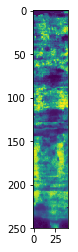

In [29]:
for i in range(len(cubes_set)):
    if (cubes_set[i]["file"]) == "PX303-Fg001-V-C01-R01_TEAR_8X5_PIECE_2X4":
        plt.imshow(cubes_set[i]["cube"])

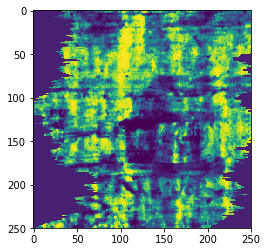

In [30]:
for i in range(len(cubes_set)):
    if (cubes_set[i]["file"]) == "PX303-Fg001-V-C01-R01_TEAR_8X5_PIECE_4X4":
        plt.imshow(cubes_set[i]["cube"])